# Imports

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

# Def

In [2]:
# Gumbel distribution (https://en.wikipedia.org/wiki/Gumbel_distribution)
def gumbel_pdf(x,mu,sigma):
    beta = sigma*(np.sqrt(6)/np.pi)
    z=(x-mu)/beta
    return (1/beta)*np.exp(-(z+np.exp(-1*z)))


def gumbel_with_controlled_t0(num_waveforms, waveform_length, loc, a, scale, noise_std=0.01, offset=0):
    """
    Add a Gumbel peak to noise, controlling the start (t0) or location (loc) of the peak.
    """
    # Define Gumbel pulse
    def gumbel_pulse(x, a, loc, scale):
        return a * np.exp(-(x - loc) / scale - np.exp(-(x - loc) / scale))
    
    # Create waveforms
    waveforms = np.zeros((num_waveforms, waveform_length))

    for i in range(num_waveforms):
        x = np.arange(waveform_length)
        
        # Generate Gumbel pulse centered at loc
        gumbel_peak = gumbel_pulse(x, a=a, loc=loc, scale=scale)
        
        # Generate Gaussian noise
        gaussian_noise = np.random.normal(0, noise_std, size=waveform_length)
        
        # Add Gumbel peak to noise and normalize
        waveforms[i] = gumbel_peak + gaussian_noise + offset
        waveforms[i] /= np.sum(waveforms[i])  # Normalize individually

    return waveforms



# a simple function to downsample an array by factor N
def downsample(x, N):
        return np.append(x,np.zeros(len(x)%N)*np.nan).reshape(-1,N).mean(axis=1)

#@nb.jit(nopython=True, cache=False)  # cache=False only for performance comparison
def numba_ix(arr, rows, cols):
    """
    Numba compatible implementation of arr[np.ix_(rows, cols)] for 2D arrays.
    from https://github.com/numba/numba/issues/5894#issuecomment-974701551
    :param arr: 2D array to be indexed
    :param rows: Row indices
    :param cols: Column indices
    :return: 2D array with the given rows and columns of the input array
    """
    one_d_index = np.zeros(len(rows) * len(cols), dtype=np.int32)
    for i, r in enumerate(rows):
        start = i * len(cols)
        one_d_index[start: start + len(cols)] = cols + arr.shape[1] * r

    arr_1d = arr.reshape((arr.shape[0] * arr.shape[1], 1))
    slice_1d = np.take(arr_1d, one_d_index)
    return slice_1d.reshape((len(rows), len(cols)))


def nnls(A, b, maxiter=None, tol=None):
    """
    based on scipy implementation. Which in turn is based on
    the algorithm given in  :doi:`10.1002/cem.889`
    """
    m, n = A.shape

    AtA = np.transpose(A) @ A
    Atb = b @ A  # Result is 1D - let NumPy figure it out

    if not maxiter:
        maxiter = 3*n
    if tol is None:
        tol = 10 * max(m, n) * np.spacing(1.)

    # Initialize vars
    x = np.zeros(n, dtype=np.float64)
    s = np.zeros(n, dtype=np.float64)
    # Inactive constraint switches
    P = np.zeros(n, dtype=bool)
    Pidx = np.arange(0,len(P),1,dtype=int)

    # Projected residual
    w = Atb.copy().astype(np.float64)  # x=0. Skip (-AtA @ x) term

    # Overall iteration counter
    # Outer loop is not counted, inner iter is counted across outer spins
    iter = 0

    while (not P.all()) and (w[~P] > tol).any():  # B
        # Get the "most" active coeff index and move to inactive set
        k = np.argmax(w * (~P))  # B.2
        P[k] = True  # B.3

        # Iteration solution
        s[:] = 0.
        # B.4
        s[P] = np.linalg.solve(numba_ix(AtA,Pidx[P],Pidx[P]), Atb[P])

        # Inner loop
        while (iter < maxiter) and (s[P].min() <= 0):  # C.1
            iter += 1
            inds = P * (s <= 0)
            alpha = (x[inds] / (x[inds] - s[inds])).min()  # C.2
            x *= (1 - alpha)
            x += alpha*s
            P[x <= tol] = False
            s[P] = np.linalg.solve(numba_ix(AtA,Pidx[P],Pidx[P]), Atb[P])
            s[~P] = 0  # C.6

        x[:] = s[:]
        w[:] = Atb - AtA @ x

        if iter == maxiter:
            return x

    return x

        

# Simulate pulse with noise

Add gaussian noise to a Gumbel dist

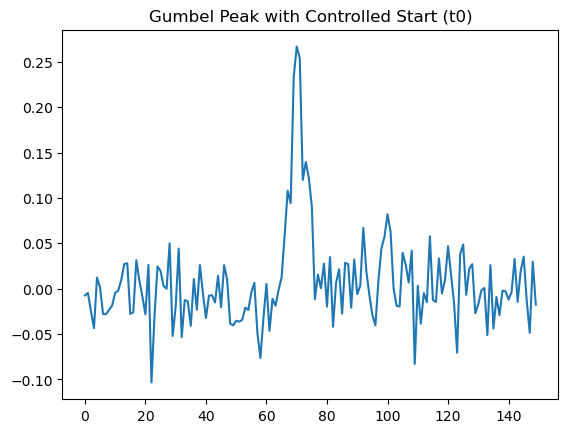

In [11]:
# Parameters
num_waveforms = 1
waveform_length = 150
loc = 70  # Start of Gumbel peak
a = 10.0   # Amplitude of Gumbel peak
scale = 2 # Scale of Gumbel peak
noise_std = 0.5
offset = 0

# Generate waveforms
waveforms = gumbel_with_controlled_t0(num_waveforms, waveform_length, loc, a, scale, noise_std, offset)

# Plot the first waveform
plt.plot(waveforms[0])
plt.title("Gumbel Peak with Controlled Start (t0)")
plt.show()


In [12]:
x = np.arange(0,150, 1)
y = waveforms[0]

In [13]:
# generate matrix
A = np.zeros((len(x),len(x)))
for i in range(len(x)):
    A[:,i] = (gumbel_pdf(x,x[i],2)) 

## 1 p.e. pulse

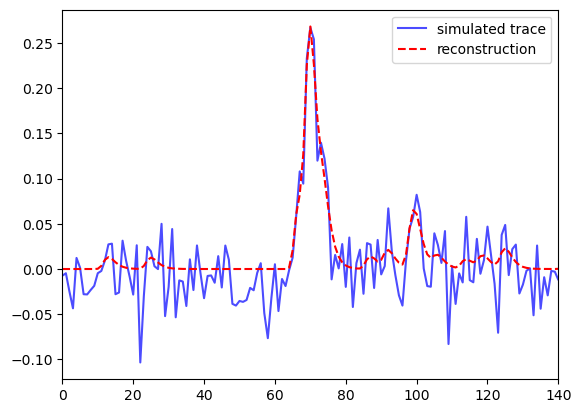

In [25]:
res = nnls(A,y,1000)
zres = np.zeros(len(x))
for i in range(len(zres)):
    zres += res[i]*gumbel_pdf(x,x[i],2)

plt.plot(x,y,label='simulated trace', color = 'blue', alpha = 0.7)
plt.plot(x,zres,label='reconstruction',ls='--', color = 'r')
plt.xlim(0,140)
plt.legend()

# Check difference between reco vs real t0

In [15]:
baseline = 0.005
shifted_res = zres-baseline
multiply =  shifted_res*np.roll(shifted_res,1)

sign = np.sign(multiply)
sign[0] = 1
integrals = {}
peak = False
current_integral = 0
current_integral_start = 0

for i,s in enumerate(sign):
    if s < 0:
        if not peak:
            current_integral = 0
            current_integral_start = x[i]
        if peak:
            integrals[(current_integral_start, x[i])] = current_integral
        peak = not peak

    if peak:
        current_integral += zres[i]*(x[1]-x[0])



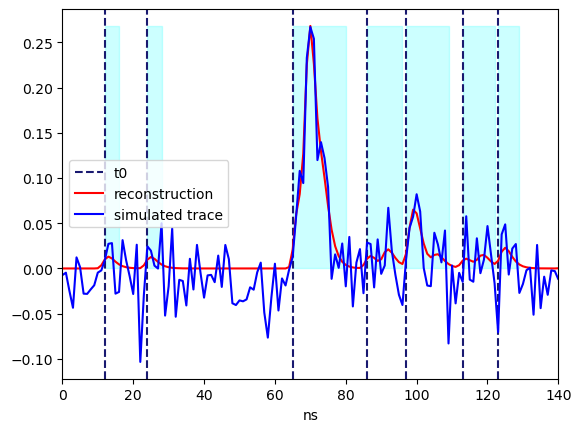

In [17]:
for key, b in integrals.items():
    plt.fill_betweenx([0, np.max(zres)], [key[0],key[0]], [key[1],key[1]], alpha =0.2, color = "cyan")
    plt.axvline(key[0], linestyle = '--', color = 'midnightblue')
plt.plot([],[], linestyle = '--', color = 'midnightblue', label = 't0')
plt.plot(x,zres,label='reconstruction', color = 'r')
plt.plot(x,y,label='simulated trace', color = 'blue')
plt.xlim(0,140)
plt.xlabel('ns')
plt.legend()

In [23]:
# Find the key with the maximum value
max_key = max(integrals, key=integrals.get)
max_value = integrals[max_key]

print(f"The maximum value is: {max_value} and its t0 is: {max_key[0]}")
print(f"Real t0 is: {loc}")


The maximum value is: 1.5625156771938449 and its t0 is: 65
Real t0 is: 70
